## Instance Segmentation Example

Last updated: 4.30.24

This notebook demonstrates how to use `pretrained-microscopy-models` to performance instance segmentation.

In this example, we build off the `mmdetection` repository to use pretrained MicroNet weights for melt pool instance segmentation in experimental advance manufacturing images.

### Import Libraries

In [1]:
import mmcv
import mmengine
from mmengine import Config
from mmengine.runner import Runner
from mmengine.visualization import Visualizer
from mmdet.apis import init_detector, inference_detector

import torch.utils.model_zoo as model_zoo
import pretrained_microscopy_models as pmm

2024-05-01 16:48:47.939548: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 16:48:47.939578: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 16:48:47.939608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 16:48:47.950654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Define Parameters and Configuration

First, we'll define the basic parameters and directories needed.

`mmdetection` wraps its functionality around configuration files. These configuration files contain data and model information that the pipeline uses. There are a multitude of configuration files that the `mmdetection` library has readily accessible. Here we provide have a sample configuration file for ResNet50 that will be leveraged in this example.

In this case, let's train using the ImageMicroNet weights.

In [2]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'image-micronet'

DATA_DIRECTORY = './data'
CONFIG_PATH = './configs/mask_rcnn_resnet50.py'

if ENCODER_WEIGHTS == 'micronet' or ENCODER_WEIGHTS == 'image-micronet':
    weights_url = pmm.util.get_pretrained_microscopynet_url(ENCODER, ENCODER_WEIGHTS)
else:
    weights_url = None

cfg = Config.fromfile(CONFIG_PATH)

Next we need to update the configuration file from the default settings `mmdetection` provides to our specific use case. The bulk of settings follow the example from: [MMDet_InstanceSeg_Tutorial](https://github.com/open-mmlab/mmdetection/blob/main/demo/MMDet_InstanceSeg_Tutorial.ipynb) with slight modifications.

In [5]:
# define classes
cfg.metainfo = dict(classes=('melt pool' ,))

# modify dataset
cfg.data_root = DATA_DIRECTORY

cfg.train_dataloader.batch_size = 4
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_root = ''
cfg.train_dataloader.dataset.ann_file = './data/annotations/train.json'
cfg.train_dataloader.dataset.data_prefix.img = ''
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.train_dataloader.batch_size = 2
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_root = ''
cfg.val_dataloader.dataset.ann_file = './data/annotations/validation.json'
cfg.val_dataloader.dataset.data_prefix.img = ''
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# data pipelines
pipeline = [{'type': 'LoadImageFromFile', 'backend_args': None},
            {'type': 'LoadAnnotations', 'with_bbox': True, 'with_mask': True},
            {'type': 'Resize', 'scale': (512, 512), 'keep_ratio': True},
            {'type': 'PackDetInputs'}]

cfg.train_dataloader.dataset.pipeline = pipeline
cfg.val_dataloader.dataset.pipeline = pipeline

cfg.train_pipeline = pipeline
cfg.test_pipeline = pipeline

# modify metric configuration
cfg.val_evaluator.ann_file = cfg.val_dataloader.dataset.ann_file
cfg.test_evaluator = cfg.val_evaluator

# modify model
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# leverage 
if weights_url is not None:
    cfg.model.backbone.init_cfg.checkpoint = weights_url

# modify hyperparameters
cfg.train_cfg.max_epochs = 25

# working dir to save files and logs.
cfg.work_dir = './output'

# evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 5

# checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = -1
cfg.default_hooks.checkpoint.save_best = 'auto'

cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10

### Model Training

In [6]:
runner = Runner.from_cfg(cfg)
runner.train()

05/01 16:50:48 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 232187101
    GPU 0: NVIDIA GeForce RTX 2080 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.2+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=co

05/01 16:50:49 - mmengine - INFO - Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
backend_args = None
data_root = './data'
dataset_type = 'CocoDataset'
default_hooks = dict(
    checkpoint=dict(interval=-1, save_best='auto', type='CheckpointHook'),
    logger=dict(interval=10, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='DetVisualizationHook'))
default_scope = 'mmdet'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
load_from = None
log_level = 'INFO'
log_processor = dict(by_epoch=True, type='LogProcessor', window_size=50)
metainfo = dict(classes=('melt pool', ))
model = dict(
    backbone=dict(
        depth=50,
        frozen_stages=1,
        init_cfg=dict(
            checkpoint=
            'https://nasa-public-data.s3.amazonaws.co

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


05/01 16:50:50 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
05/01 16:50:50 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

MaskRCNN(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)

### Evaluate Performance

Let's evaluate our trained model by visualizing a prediction for a sample from the validation set.

Note: In this demo we use a small dataset with no hyperparameter tuning as a proof of concept. Increasing out dataset size, encoder complexity, and conducting hyperparameter tuning would result in a much more robust and accurate model.

Loads checkpoint by local backend from path: ./output/epoch_25.pth


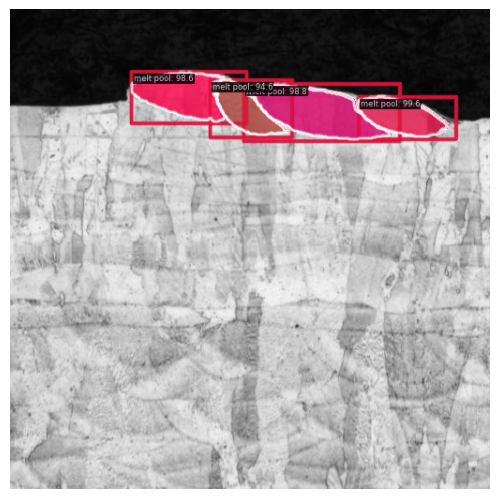

In [12]:
img = mmcv.imread('./data/validation/Slice-10Bottom_7168_0_7680_512.png', channel_order='rgb')

checkpoint_file = './output/epoch_25.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
result = inference_detector(model, img)

visualizer_now = Visualizer.get_current_instance()
visualizer_now.dataset_meta = model.dataset_meta

visualizer_now.add_datasample(
    'result',
    img,
    data_sample=result,
    wait_time=0,
    out_file=None,
    draw_gt=False,
    pred_score_thr=0.5
)

visualizer_now.show()